# Laboratorio 1 - Imágenes y Visión (ML)

**Integrantes:**

* Juan Sebastián Pinzón Roncancio (201915773)

* David Santiago Ortiz Almanza (201913600)


# Librerías 

A continuación, se importan las librerías utilizadas para el desarrollo del Laboratorio I.

In [296]:
import os
import cv2
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore', category=UserWarning)
np.random.seed(42)

In [222]:
# Directorio de las imágenes
base_dir = "./data/"
class_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
class_names = [os.path.basename(dir).replace('_resized', '').replace('-resize', '').replace('-Resized', '').capitalize() for dir in class_dirs]

# Exploración conjunto de datos

## Visualización Básica

A continuación, se realizar una inspección visual de las imágenes presentes en el dataset. En concreto se revisa una imagen por cada una de las clases presentes para entender el significado de cada clase.

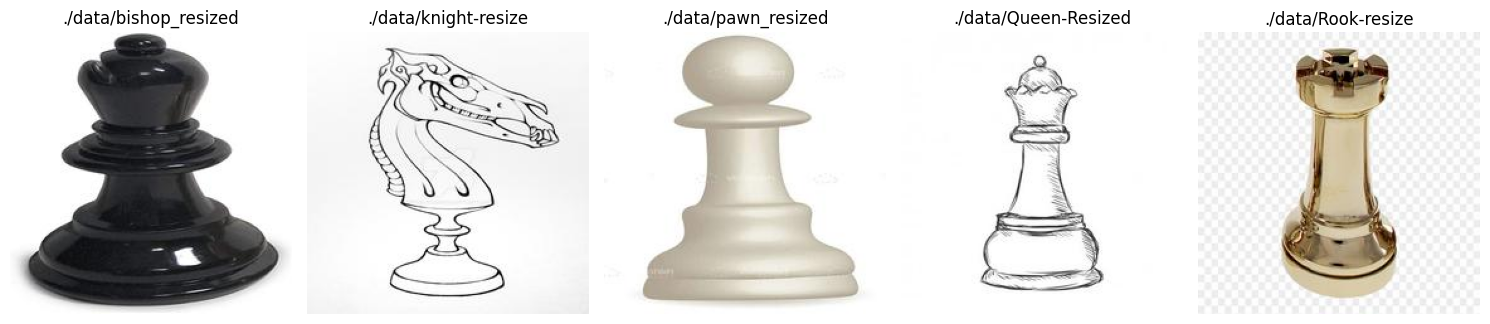

In [223]:
# 1. Visualización Básica
plt.figure(figsize=(15, 10))
for idx, class_dir in enumerate(class_dirs):
    img_names = os.listdir(class_dir)
    random_img = cv2.imread(os.path.join(class_dir, np.random.choice(img_names)))
    random_img = cv2.cvtColor(random_img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, len(class_dirs), idx + 1)
    plt.imshow(random_img)
    plt.title(class_dir)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Análisis de distribución de imágenes por clase

Posteriormente, se realizó un diagrama de barras para poder visualizar la cantidad de muestras presentes por cada una de las clases. 

Se puede observar que el conjunto de datos está un poco desbalanceado, en especial por la clase "pawn" que solo contiene 82 muestras mientras que la clase "knight" tiene 174.

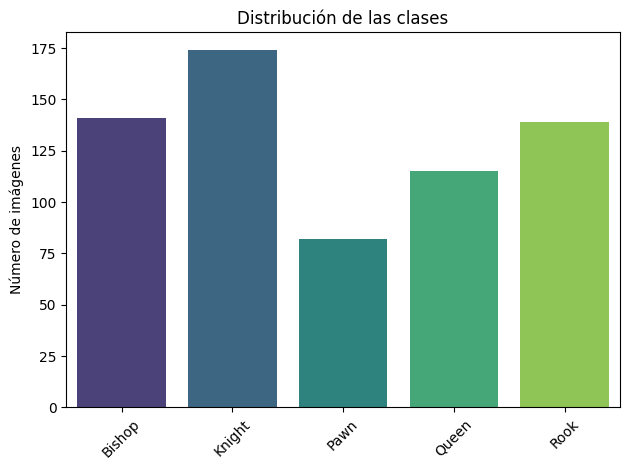

In [224]:
class_counts = [len(os.listdir(class_dir)) for class_dir in class_dirs]
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Distribución de las clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Análisis del tamaño de las imágenes

A continuación, se procedió a realizar una inspección de la resolución de las imágenes presentes en el dataset. Esto es importante, puesto que, para entrenar un modelo de aprendizaje se requiere que todas las imágenes tengan las mismas dimensiones.

Como se puede ver, todas las imágenes presentes en el dataset tienen una resolución de 224 x 224 de 3 canales (RGB). Razón por la cuál no es necesario cambiar el tamaño de ninguna imagen.

In [225]:
# 3. Tamaño y Formato de las Imágenes
img_shapes = []
for class_dir in class_dirs:
    for img_name in os.listdir(class_dir):
        img = cv2.imread(os.path.join(class_dir, img_name))
        img_shapes.append(img.shape)
img_shapes = np.array(img_shapes)
unique_shapes = np.unique(img_shapes, axis=0)
print(f"Formas únicas de imágenes: {unique_shapes}")

Formas únicas de imágenes: [[224 224   3]]


## Análisis de histograma, brillo y contraste de las imágenes por clase

A continuación se realiza una comparación de la distribución de los histogramas, el brillo y el contraste de las imágenes presentes en cada una de las clases para el entendimiento de los datos respectivos.

In [226]:
def compute_image_metrics(image_path):
    """Compute mean RGB, brightness, and contrast for an image."""
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    brightness = np.mean(grayscale)
    contrast = np.std(grayscale)
    mean_rgb = np.mean(image, axis=(0, 1))
    return mean_rgb, brightness, contrast

data_metrics = {'Red': [], 'Green': [], 'Blue': [], 'Brightness': [], 'Contrast': []}
main_colors = {'Red': 0, 'Green': 1/3, 'Blue': 2/3, 'Brightness': 2/3, 'Contrast': 0}

for class_dir in class_dirs:
    metrics_values = [compute_image_metrics(os.path.join(class_dir, image_name)) for image_name in os.listdir(class_dir)]
    data_metrics['Red'].append([val[0][0] for val in metrics_values])
    data_metrics['Green'].append([val[0][1] for val in metrics_values])
    data_metrics['Blue'].append([val[0][2] for val in metrics_values])
    data_metrics['Brightness'].append([val[1] for val in metrics_values])
    data_metrics['Contrast'].append([val[2] for val in metrics_values])

### Comparación de histogramas por canal (RGB) por clase.

A continuación se puede observar un boxplot de las distribuciones de las intensidades por cada uno de los canales (R, G y B) agrupados por cada clase. Se puede observar que existen algunas imágenes que están muy alejados de la media y pueden significar que existen outlieres en los datos.

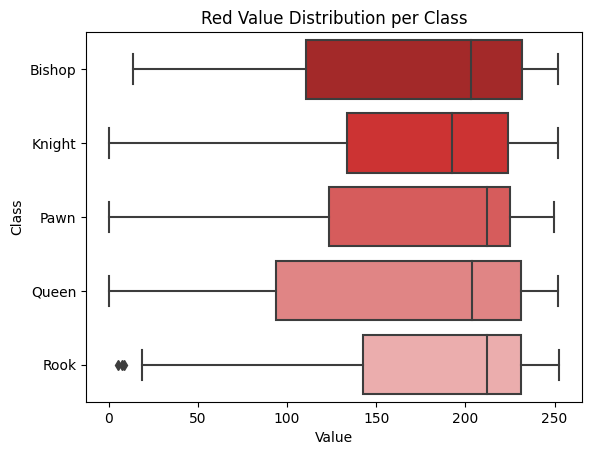

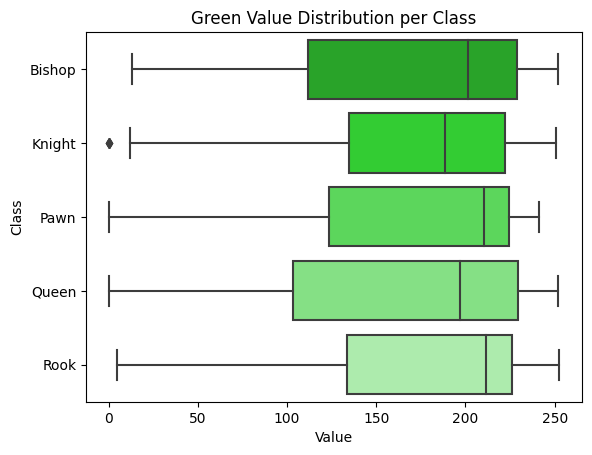

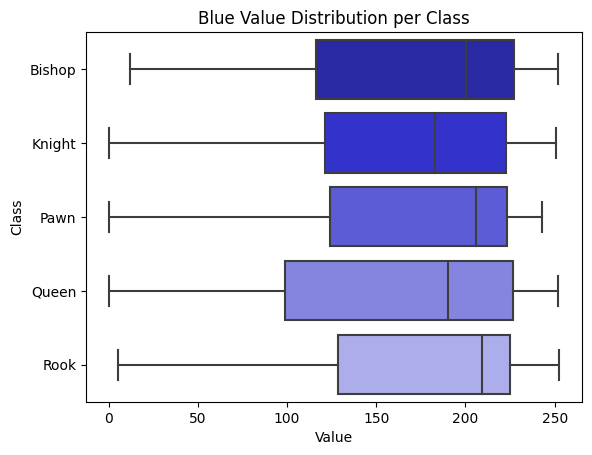

In [227]:
def plot_rgb(data, labels, main_colors):
    for color_name, hue_value in main_colors.items():
        color_palette = [sns.hls_palette(1, h=hue_value, l=l, s=0.8)[0] for l in np.linspace(0.4, 0.8, len(labels))]
        all_data = [{'Class': labels[i], 'Value': value} 
                    for i, class_data in enumerate(data[color_name]) 
                    for value in class_data]
        df = pd.DataFrame(all_data)
        sns.boxplot(x='Value', y='Class', data=df, palette=color_palette)
        plt.title(f"{color_name} Value Distribution per Class")
        plt.show()

rgb_colors = {'Red': 0, 'Green': 1/3, 'Blue': 2/3}
plot_rgb(data_metrics, class_names, rgb_colors)

### Comparación de brillo (Intensidad) de las imágenes por cada clase

A continuación, se puede ver un boxplot que representa la comparación de la distribución del brillo de las imágenes por cada clase, se puede observar que en general todas las clases tienen un promedio similar, sin embargo, existen algunos outliers con brillo muy bajo, lo que significa que existen imágenes muy oscuras.

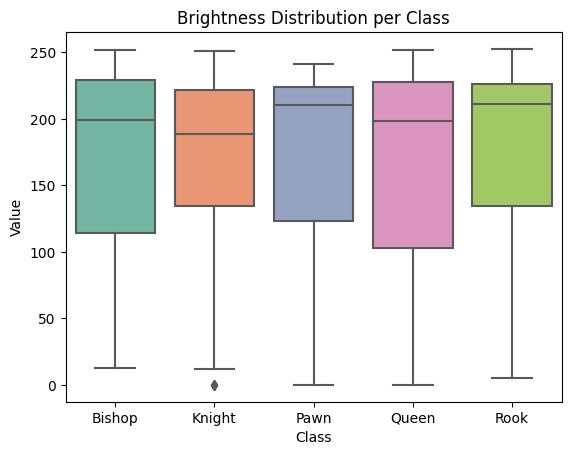

In [228]:
def plot_brightness(data, labels):
    color_palette = sns.color_palette("Set2", len(labels))
    all_data = [{'Class': labels[i], 'Value': value} 
                for i, class_data in enumerate(data['Brightness']) 
                for value in class_data]
    df = pd.DataFrame(all_data)
    sns.boxplot(x='Class', y='Value', data=df, palette=color_palette, orient="v")
    plt.title("Brightness Distribution per Class")
    plt.show()


plot_brightness(data_metrics, class_names)

### Comparación del contraste (std) de las imágenes por clase

Por último, se puede observar la comparación de distribución de contrastes de las imágenes por cada clase, es de notar que todas las clases parecen tener una distribución similar y no se ven outliers a simple vista.

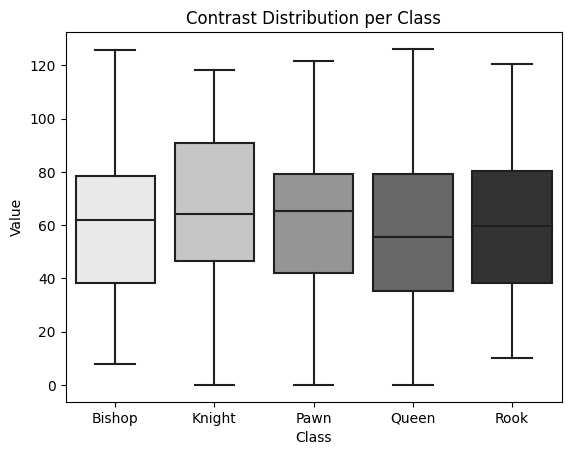

In [229]:
def plot_contrast(data, labels):
    color_palette = sns.color_palette("Greys", len(labels))
    all_data = [{'Class': labels[i], 'Value': value} 
                for i, class_data in enumerate(data['Contrast']) 
                for value in class_data]
    df = pd.DataFrame(all_data)
    sns.boxplot(x='Class', y='Value', data=df, palette=color_palette, orient="v")
    plt.title("Contrast Distribution per Class")
    plt.show()

plot_contrast(data_metrics, class_names)

# Preprocesamiento de las Imágenes

## Detección de Outliers

A continuación, se procede a detectar outlieres basado en el entendimiento de los datos realizado en la sección anterior. Por esta razón, se filtraron todas las imágenes que estén más alejados que 2.3 la desviación estándar tanto del brillo promedio por clase como del contraste promedio por clase. 

Enseguida se pueden observar los outliers detectados, los cuáles corresponden a imágenes muy oscuras (incluso negras totalmente), que pueden afectar el desempeño del modelo de aprendizaje.

Outliers for class './data/bishop_resized': ['00000167_resized.jpg']
Outliers for class './data/knight-resize': ['00000046_resized.jpg', '00000102_resized.jpg', '00000267_resized.jpg', '00000289_resized.jpg']
Outliers for class './data/pawn_resized': ['00000014_resized.jpg', '00000139_resized.jpg']
Outliers for class './data/Queen-Resized': ['00000052_resized.jpg', '00000122_resized.jpg']
Outliers for class './data/Rook-resize': ['00000053_resized.jpg', '00000097_resized.jpg', '00000109_resized.jpg', '00000131_resized.jpg']


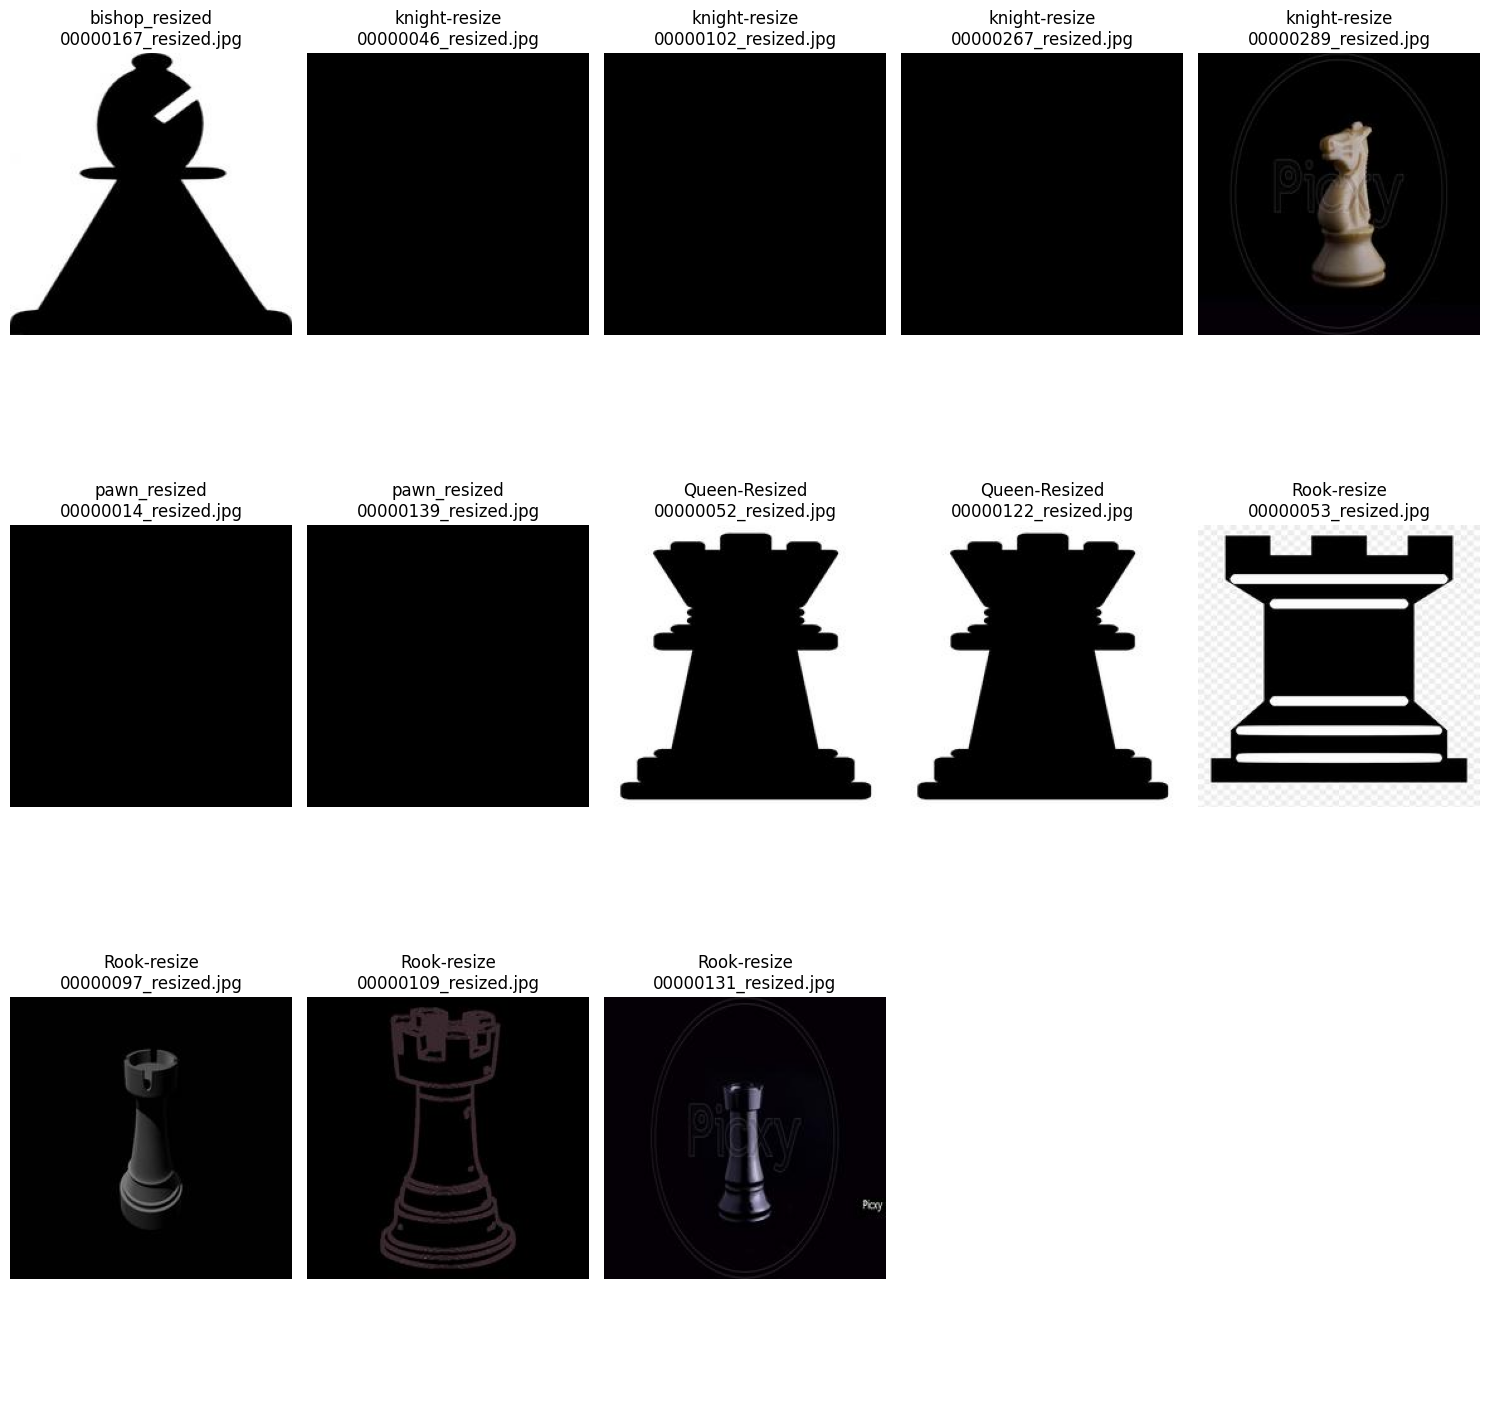

In [230]:
outliers = {}
for class_dir_idx in range(len(class_dirs)):
    brightness_mean, brightness_std = np.mean(data_metrics['Brightness'][class_dir_idx]), np.std(data_metrics['Brightness'][class_dir_idx])
    contrast_mean, contrast_std = np.mean(data_metrics['Contrast'][class_dir_idx]), np.std(data_metrics['Contrast'][class_dir_idx])
    outlier_images = []
    class_dir = class_dirs[class_dir_idx]
    for idx, filename in enumerate(os.listdir(class_dir)):
        image_path = os.path.join(class_dir, filename)
        if (abs(data_metrics['Brightness'][class_dir_idx][idx] - brightness_mean) > 2.3 * brightness_std) or (abs(data_metrics['Contrast'][class_dir_idx][idx] - contrast_mean) > 2.25 * contrast_std):
            outlier_images.append(filename)
    outliers[class_dir] = outlier_images
    
for class_name, outlier_list in outliers.items():
    print(f"Outliers for class '{class_name}': {outlier_list}")
    
def plot_outliers(outliers, class_dirs):  
    total_outliers = sum([len(images) for images in outliers.values()])
    cols = 5 
    rows = int(np.ceil(total_outliers / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    idx = 0
    for class_dir, outlier_images in zip(class_dirs, outliers.values()):
        for image_name in outlier_images:
            image = cv2.imread(os.path.join(class_dir, image_name), cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax = axes[idx // cols, idx % cols]
            ax.imshow(image)
            ax.set_title(f"{os.path.basename(class_dir)}\n{image_name}")
            ax.axis('off')
            idx += 1
    while idx < rows * cols:
        axes[idx // cols, idx % cols].axis('off')
        idx += 1
    plt.tight_layout()
    plt.show()
plot_outliers(outliers, class_dirs)

## Data Augmentation para balanceo de clases

En la etapa de exploración de datos, se encontró que existe un ligero desbalance de clases (siendo la clase Knight la más afectada), por esta razón, se decidió realizar un aumento de los datos en aquellas clases con pocas muestras. El aumento de los datos consistió en generar imágenes a partir de las originales realizando transformaciones aleatorias como recortes, giros, ruido, cambio de contraste, cambio de histograma, etc.

A continuación, se puede observar algunos ejemplos de los datos aumentados por cada clase.

Data augmentation for balancing is completed.


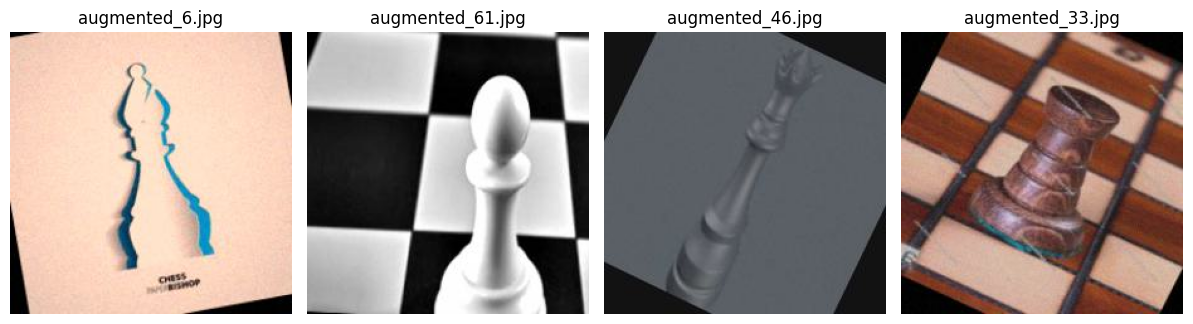

In [326]:
# Augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # random crops
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

# Image counts
counts = [len(os.listdir(class_dir))-len(outliers[class_dir]) for class_dir in class_dirs]

# Augment and save images
for directory, count in zip(class_dirs, counts):
    num_augmentations = max(counts) - count
    if num_augmentations > 0:
        image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f not in outliers.get(class_dir, [])]
        augmented_images = []
        for _ in range(num_augmentations):
            # Randomly select an image for augmentation
            selected_image_path = os.path.join(directory, np.random.choice(image_files))
            image = imageio.imread(selected_image_path)
            # Augment the image
            augmented_image = seq(image=image)
            augmented_images.append(augmented_image)
        # Save the augmented images
        for idx, aug_image in enumerate(augmented_images):
            augmented_image_path = os.path.join(directory, f"augmented_{idx}.jpg")
            imageio.imsave(augmented_image_path, aug_image)

print("Data augmentation for balancing is completed.")

# Visualización de ejemplos de imágenes aumentadas
plt.figure(figsize=(15, 10))
for idx, class_dir in enumerate([class_dir for class_dir in class_dirs if class_dir!="./data/knight-resize"]):
    img_names = [img for img in os.listdir(class_dir) if img.startswith("augmented_")]
    random_img_name = np.random.choice(img_names)
    random_img = cv2.imread(os.path.join(class_dir, random_img_name))
    random_img = cv2.cvtColor(random_img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, len(class_dirs), idx + 1)
    plt.imshow(random_img)
    plt.title(random_img_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Análisis de distribución de imágenes por clase después del aumento de datos

A continuación, se puede observar que después de realizar el aumento de datos por clase se consiguió obtener un dataset completamente balanceado, lo cuál ayudará al aprendizaje de nuestro modelo.

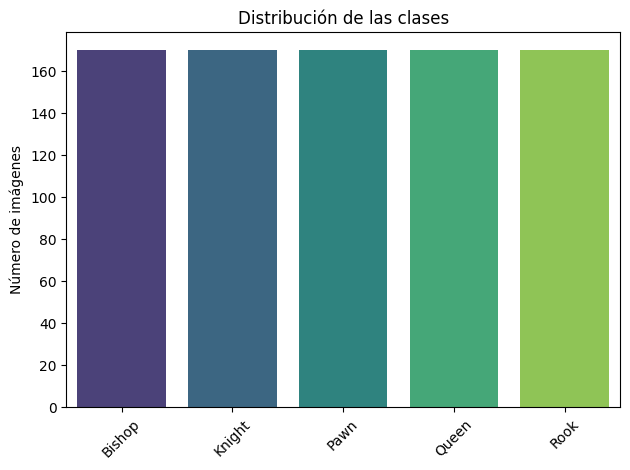

In [327]:
class_counts = [len(os.listdir(class_dir))-len(outliers[class_dir]) for class_dir in class_dirs]
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Distribución de las clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## División de los datos: Entrenamiento (80%) - Test (20%)

Una vez eliminadas las imágenes que se consideraron outliers y agregadas las imagenes aumentadas para balancear las clases, se procedió a realizar una división en los datos en dos conjuntos independientes: Conjunto de entrenamiento (80%) y conjunto de prueba (20%).

In [233]:
train_images = []
test_images = []
train_labels = []
test_labels = []
test_size = 0.2 

for class_dir, class_name in zip(class_dirs, class_names):
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg')) and img not in outliers.get(class_dir, [])]
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
    train_images.extend(train_imgs)
    test_images.extend(test_imgs)
    train_labels.extend([class_name] * len(train_imgs))
    test_labels.extend([class_name] * len(test_imgs))

print("Tamaño conjunto de entrenamiento:", len(train_images), f"({round(100*len(train_images)/(len(train_images)+len(test_images)), 2)}%)")
print("Tamaño conjunto de test:", len(test_images), f"({round(100*len(test_images)/(len(train_images)+len(test_images)), 2)}%)")

Tamaño conjunto de entrenamiento: 680 (80.0%)
Tamaño conjunto de test: 170 (20.0%)


## Procesamiento de Imagenes para la calidad y el modelamiento

Una vez tenemos los datos divididos en ambos conjuntos, se preprocesaron las imágenes con 3 objetivos: mejorar la cálidad de las imágenes, estandarizar las imagenes y obtener una representación adecuada para utilizar KNN como algoritmo de aprendizaje supervisado.

Así pues, se convirtieron todas las imágenes a escala de grises, se ecualizó su histograma, se aplicó un filtro gaussiano, se normalizaron los canales y por último, se convirtió a un vector 1D.

In [234]:
def preprocess_image(img_path):
    # Load the image as Gray Scale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Histogram Equalization
    equalized_image = cv2.equalizeHist(image.astype('uint8'))
    # Noise Reduction (Gaussian Blurring)
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    # Normalization
    normalized_image = blurred_image / 255.0
    # Flatten the image
    flattened_image = normalized_image.ravel()
    return flattened_image

# Apply preprocessing to all train images
preprocessed_train_images = [preprocess_image(img_path) for img_path in train_images]
preprocessed_test_images = [preprocess_image(img_path) for img_path in test_images]

# En resumen ¿Que particularidades presentan los datos y qué técnicas de preprocesamiento se pueden aplicar?

Las particularidades que presentan los datos son:

* **Desbalance de clases:** El conjunto de datos no está equilibrado, con la clase "pawn" teniendo significativamente menos muestras que la clase "knight".

* **Uniformidad de resolución:** Todas las imágenes en el conjunto de datos tienen una resolución de 224 x 224 y poseen 3 canales (RGB).

* **Posibles datos atípicos (outliers):** Hay indicios de que ciertas imágenes tienen intensidades de color que están muy alejadas de la media, lo que sugiere la presencia de outliers.

* **Variabilidad de brillo:** Aunque el brillo promedio por clase es similar, algunas imágenes presentan un brillo muy bajo, indicando que hay imágenes demasiado oscuras.

Las técnicas de preprocesamiento que se aplicaron son:

* **Detección y eliminación de outliers:** Se filtraron imágenes basadas en criterios de brillo y contraste, eliminando aquellas que estuvieran más alejadas que 2.3 veces la desviación estándar del brillo y contraste promedio por clase.

* **Aumento de datos (Data Augmentation):** Para combatir el desbalance de clases, se generaron imágenes adicionales a partir de las imágenes originales aplicando transformaciones aleatorias como recortes, giros, adición de ruido, cambio de contraste, ajuste de histograma, entre otros.

* **División de datos:** Se dividió el conjunto de datos en dos grupos: 80% para entrenamiento y 20% para prueba.

Preprocesamiento específico de imágenes:

* **Conversión a escala de grises:** Las imágenes se transformaron a escala de grises para reducir la dimensionalidad y posiblemente mejorar el rendimiento del modelo.

* **Ecualización del histograma:** Esto mejora el contraste de las imágenes, distribuyendo de manera uniforme las intensidades de luz en la imagen.

* **Aplicación de un filtro gaussiano:** Este filtro reduce el ruido y los detalles innecesarios en las imágenes.

* **Normalización:** Se normalizaron las intensidades de los píxeles para llevarlas a un rango entre [0, 1].

* **Flatten o conversión a vector 1D:** Para que las imágenes pudieran ser usadas con el algoritmo KNN, se convirtieron a un formato unidimensional.

Estas técnicas de preprocesamiento fueron aplicadas con el objetivo de mejorar la calidad y representación de las imágenes para ser utilizadas en el entrenamiento de un modelo, en este caso, KNN.

# Modelamiento para la Detección y clasificación de Piezas de Ajedrez (KNN)

## Validación Cruzada (K-Fold) de KNN con parámetros por defecto (F1-Score)

Una vez teniendo los datos preprocesados se procedió a utilizar KNN con sus parámetros por defecto para observar su desempeño base, para esto se utilizó una validación cruzada con k=5 y como métrica el F1-Score. Se puede observar que el F1 promedio obtenido fue de 0.355.

In [235]:
cv_scores = cross_val_score(KNeighborsClassifier(), preprocessed_train_images, train_labels, cv=5, scoring=make_scorer(f1_score, average='weighted'))
mean_f1 = cv_scores.mean()
print("Resultados de Validación Cruzada (K=5):")
print("F1 Promedio: " + str(mean_f1))
print("F1 por Pliegue: " + str(cv_scores))

Resultados de Validación Cruzada (K=5):
F1 Promedio: 0.3546654088334091
F1 por Pliegue: [0.38063472 0.38069407 0.32501326 0.38641219 0.3005728 ]


## Búsqueda de mejores hiperpárametros a través de validación cruzada usando como métrica F1-Score

Ahora bien, se hizó una búsqueda en malla con validación cruzada (k=5) para encontrar los mejores hiperpárametros para KNN con los datos dados. A continuación, se puede ver que los mejores hiperpárametros encontrados fueron {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'} y se obtuvo una F1 promedio de 0.37 (una mejora del 2%).

In [332]:
start = time.time()

param_grid = {
    'n_neighbors': [5, 8, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid , cv=5, scoring=make_scorer(f1_score, average='weighted'), verbose=0, n_jobs=-1)

grid_search.fit(preprocessed_train_images, train_labels)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))
print("Mejores hiperparámetros: " + str(grid_search.best_params_))
print("Mejor F1 promedio (K=5): " + str(grid_search.best_score_))

Tiempo de entrenamiento: 174.55 segundos
Mejores hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
Mejor F1 promedio (K=5): 0.37100010272232276


## Evaluación del mejor modelo encontrado (Predicción conjunto test)

Una vez encontrados los mejores hiperparámetros, se procedió a probar dicho modelo con el conjunto test para darnos una idea del desempeño esperado en unos datos nunca antes vistos. Se puede observar que el desempeño obtenido fue de un F1 promedio de 0.417.

In [335]:
modelo = KNeighborsClassifier(metric='euclidean', n_neighbors=20, weights='distance')
modelo.fit(preprocessed_train_images, train_labels)
y_pred =  modelo.predict(preprocessed_test_images)
print(classification_report(test_labels, y_pred, digits=3))

              precision    recall  f1-score   support

      Bishop      0.333     0.471     0.390        34
      Knight      0.783     0.529     0.632        34
        Pawn      0.346     0.265     0.300        34
       Queen      0.341     0.441     0.385        34
        Rook      0.414     0.353     0.381        34

    accuracy                          0.412       170
   macro avg      0.443     0.412     0.417       170
weighted avg      0.443     0.412     0.417       170



### Matriz de confusión del desempeño en el conjunto test

A continuación se puede observar la matriz de confusión resultante de utilizar el mejor modelo encontrado para predecir los labels del conjunto test.

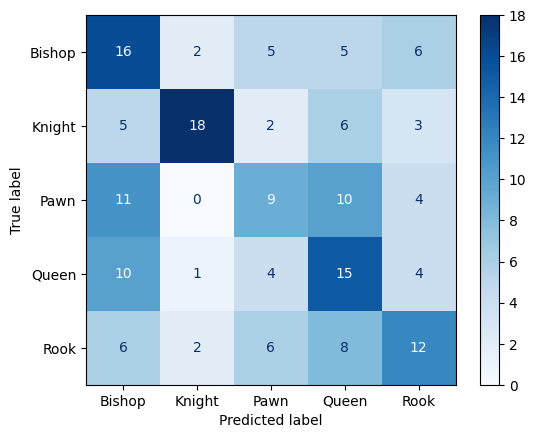

In [336]:
display_labels = np.unique(test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, y_pred), display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# En resumen ¿Qué resultados obtiene? ¿Qué ventajas y desventajas tiene este modelo para el problema planteado?

**¿Qué resultados obtiene?**

* El modelo inicial (sin ajuste de hiperparámetros) tuvo un rendimiento de F1-Score de 0.355.

* Después de la optimización de hiperparámetros, el rendimiento mejoró ligeramente a un F1-Score de 0.37 en la validación.

* Al evaluar el modelo optimizado en el conjunto de prueba, se obtuvo un rendimiento de F1-Score de 0.417.

**¿Qué ventajas y desventajas tiene este modelo para el problema planteado?**

**Ventajas:**

* Simple y fácil de entender: KNN es un algoritmo intuitivo que no requiere entrenamiento explícito, lo que puede facilitar su implementación.

* Sensible a características locales: Dada su naturaleza de basarse en vecinos cercanos, KNN puede detectar patrones locales en los datos.

* Flexibilidad: La capacidad de ajustar hiperparámetros, como el número de vecinos o la métrica de distancia, permite adaptar el modelo a diferentes distribuciones de datos.

**Desventajas:**

* Tiempo de predicción: Como KNN requiere comparar una muestra con todas las demás en el conjunto de entrenamiento, puede ser lento en conjuntos de datos grandes.

* Ruido y outliers: KNN puede ser sensible al ruido y a los valores atípicos, lo que podría afectar su rendimiento.

* Dimensionalidad: KNN puede no funcionar bien cuando el número de características es muy alto, ya que las distancias en espacios de alta dimensión tienden a ser menos significativas.

En el contexto del problema de clasificación de piezas de ajedrez, el F1-Score de 0.417 sugiere que hay margen de mejora y podría ser útil considerar otros algoritmos o técnicas adicionales de preprocesamiento y extracción de características para mejorar el rendimiento.

# Implementación de PCA para la reducción de la dimensionalidad

Por último, se aplicó Principal Component Analysis a los datos preprocesados con el fin de reducir la dimensionalidad de los mismos, quendandonos solo con las características más informativas. Esto en principio disminuye el tiempo de entrenamiento y predicción (puesto que ahora los vectores son más pequeños) y podría mejorar el desempeño al eliminar características menos informativas que podrían agregar ruido.

## Aplicación de PCA al conjunto de entrenamiento y test (conservando 90% de la varianza)

A continuación se aplica PCA tanto al conjunto de entranamiento como al conjunto de prueba conservando el 90% de la varianza.

In [285]:
pca = PCA(n_components=0.9) 
X_train_pca = pca.fit_transform(preprocessed_train_images)
X_test_pca = pca.transform(preprocessed_test_images)

## Validación Cruzada (K-Fold) de KNN con parámetros por defecto (F1-Score)

Ahora se utiliza KNN con sus hierparámetros por defecto junto a una validación cruzada (k=5) para observar el desempeño base de este algoritmo en los datos preprocesados y con PCA. Se puede observar que su F1 promedio es de 0.403 (5% mejor que lo obtenido sin PCA).

In [286]:
cv_scores = cross_val_score(KNeighborsClassifier(), X_train_pca, train_labels, cv=5, scoring=make_scorer(f1_score, average='weighted'))
mean_f1 = cv_scores.mean()
print("Resultados de Validación Cruzada (K=5):")
print("F1 Promedio: " + str(mean_f1))
print("F1 por Pliegue: " + str(cv_scores))

Resultados de Validación Cruzada (K=5):
F1 Promedio: 0.40305535864935793
F1 por Pliegue: [0.4439621  0.48421248 0.37249847 0.34206821 0.37253554]


## Búsqueda de mejores hiperpárametros a través de validación cruzada usando como métrica F1-Score

Ahora bien, se hizó una búsqueda en malla con validación cruzada (k=5) para encontrar los mejores hiperpárametros para KNN con los datos preprocesados con PCA. A continuación, se puede ver que los mejores hiperpárametros encontrados fueron {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'} y se obtuvo una F1 promedio de 0.403 (una mejora del 3% respecto al mejor modelo sin PCA).

Además, se puede notar que el tiempo de entrenamiento pasó de 175 segundos a 5 segundos, lo que significa que entrenar y predecir con los datos con PCA es 35 veces más rápido.

In [322]:
start = time.time()

param_grid = {
    'n_neighbors': [5, 8, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 3]
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid , cv=5, scoring=make_scorer(f1_score, average='weighted'), verbose=0, n_jobs=-1)

grid_search.fit(X_train_pca, train_labels)

end = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(end - start))
print("Mejores hiperparámetros: " + str(grid_search.best_params_))
print("Mejor F1 promedio (K=5): " + str(grid_search.best_score_))

Tiempo de entrenamiento: 5.19 segundos
Mejores hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Mejor F1 promedio (K=5): 0.40305535864935793


## Evaluación del mejor modelo encontrado (Predicción conjunto test)

Por último, se procedió a probar el mejor modelo encontrado con PCA con el conjunto test para darnos una idea del desempeño esperado en unos datos nunca antes vistos. Se puede observar que el desempeño obtenido fue de un F1 promedio de 0.446 (Una mejora del 3% respecto a los resultados obtenidos sin PCA).

In [330]:
modelo = KNeighborsClassifier(metric='euclidean',n_neighbors=5, weights='distance', p=1)
modelo.fit(X_train_pca, train_labels)
y_pred =  modelo.predict(X_test_pca)
print(classification_report(test_labels, y_pred, digits=3))

              precision    recall  f1-score   support

      Bishop      0.400     0.353     0.375        34
      Knight      0.679     0.559     0.613        34
        Pawn      0.500     0.441     0.469        34
       Queen      0.317     0.382     0.347        34
        Rook      0.390     0.471     0.427        34

    accuracy                          0.441       170
   macro avg      0.457     0.441     0.446       170
weighted avg      0.457     0.441     0.446       170



### Matriz de confusión del desempeño en el conjunto test

A continuación se puede observar la matriz de confusión resultante de utilizar el mejor modelo encontrado usando PCA para predecir los labels del conjunto test.

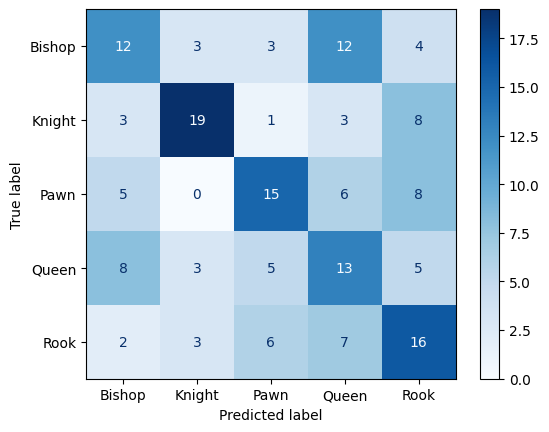

In [331]:
display_labels = np.unique(test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, y_pred), display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# En resumen  ¿Cómo afecta la reducción de dimensionalidad al desempeño del modelo KNN previamente entrenado?


La reducción de dimensionalidad mediante el uso de Principal Component Analysis (PCA) tuvo varias repercusiones significativas en el desempeño y eficiencia del modelo KNN previamente entrenado:

**Mejora en el Desempeño:**

* Sin PCA, el KNN con parámetros por defecto arrojó un F1-Score promedio de 0.355. Con PCA, este mismo modelo (sin ajuste de hiperparámetros) logró un F1-Score promedio de 0.403, lo que representa una mejora del 5%.

* En la búsqueda de hiperparámetros, el mejor modelo sin PCA alcanzó un F1-Score promedio de 0.37. Sin embargo, con PCA, el mejor modelo (ajustado) obtuvo un F1-Score promedio de 0.403, una mejora del 3% con respecto al mejor modelo sin PCA.

* Al probar con el conjunto de test, el modelo con PCA logró un F1-Score promedio de 0.446, lo que representa una mejora del 3% con respecto a los resultados obtenidos sin PCA.

**Reducción en el Tiempo de Entrenamiento:**

* El tiempo de entrenamiento del modelo se redujo dramáticamente de 175 segundos a solo 5 segundos al usar PCA. Esto indica que el entrenamiento y la predicción con datos transformados por PCA son 35 veces más rápidos.

**Conservación de la Varianza:**

* A pesar de la reducción de dimensionalidad, PCA conservó el 90% de la varianza de los datos, lo que significa que la mayoría de la información contenida en el conjunto de datos original aún está presente en los datos transformados.